In [ ]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from transformers import HubertForSequenceClassification, AutoProcessor, HubertConfig
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tqdm import tqdm
import pickle
import torch.nn.functional as F
import numpy as np
from google.colab import drive

# Google Drive'ı bağla
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, processor, target_length=160000):
        self.audio_paths = audio_paths
        self.labels = labels
        self.processor = processor
        self.target_length = target_length

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        file_path = self.audio_paths[idx]
        label = self.labels[idx]
        waveform, sr = torchaudio.load(file_path)
        waveform = waveform.squeeze()

        if waveform.size(0) < self.target_length:
            waveform = F.pad(waveform, (0, self.target_length - waveform.size(0)))
        else:
            waveform = waveform[:self.target_length]

        inputs = self.processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)
        return inputs.input_values[0], label

def load_data(base_dir, categories, notes):
    file_paths, labels = [], []
    label_map = {note: idx for idx, note in enumerate(notes)}

    for category in categories:
        for note in notes:
            path = os.path.join(base_dir, category, note)
            if not os.path.exists(path):
                print(f"Warning: {path} does not exist.")
                continue
            files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".wav")]
            file_paths.extend(files)
            labels.extend([label_map[note]] * len(files))
    return file_paths, labels

def collate_fn(batch):
    inputs = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True)
    return inputs_padded, torch.tensor(labels)

processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertForSequenceClassification.from_pretrained("facebook/hubert-large-ls960-ft")

config = HubertConfig.from_pretrained("facebook/hubert-large-ls960-ft", num_labels=12)

model = HubertForSequenceClassification.from_pretrained(
    "facebook/hubert-large-ls960-ft",
    config=config,
    torch_dtype=torch.float32
).to(device)

train_audio_paths, train_labels = load_data("/content/drive/MyDrive/processed/train", ["akortlu", "akortsuz"], ["Do", "Do#", "Re", "Re#", "Mi", "Fa", "Fa#", "Sol", "Sol#", "La", "La#", "Si"])
val_audio_paths, val_labels = load_data("/content/drive/MyDrive/processed/val", ["akortlu", "akortsuz"], ["Do", "Do#", "Re", "Re#", "Mi", "Fa", "Fa#", "Sol", "Sol#", "La", "La#", "Si"])

train_dataset = AudioDataset(train_audio_paths, train_labels, processor)
val_dataset = AudioDataset(val_audio_paths, val_labels, processor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

output_dir = "/content/drive/MyDrive/model"

def train_model(train_loader, val_loader, model, processor, epochs, output_dir):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    loss_fn = torch.nn.CrossEntropyLoss()
    model.to(device)

    best_accuracy = 0
    metrics_history = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_preds, train_targets = [], []
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs).logits
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                train_preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())
                train_targets.extend(labels.cpu().numpy())
                pbar.update(1)

        train_accuracy = accuracy_score(train_targets, train_preds)
        print(f"Epoch {epoch + 1}: Train Loss: {total_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        model.eval()
        total_val_loss = 0
        val_targets, val_preds = [], []
        val_probs = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).logits
                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                val_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())

        val_accuracy = accuracy_score(val_targets, val_preds)
        precision = precision_score(val_targets, val_preds, average="weighted", zero_division=1)
        recall = recall_score(val_targets, val_preds, average="weighted", zero_division=1)
        f1 = f1_score(val_targets, val_preds, average="weighted", zero_division=1)

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(model.config.num_labels):
            fpr[i], tpr[i], _ = roc_curve(val_targets, np.array(val_probs)[:, i], pos_label=i)
            roc_auc[i] = auc(fpr[i], tpr[i])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(model.config.num_labels)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(model.config.num_labels):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        mean_tpr /= model.config.num_labels
        macro_roc_auc = auc(all_fpr, mean_tpr)

        metrics = {
            "epoch": epoch + 1,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
            "train_loss": total_train_loss,
            "val_loss": total_val_loss,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "roc_auc": roc_auc,
            "macro_roc_auc": macro_roc_auc,
            "fpr": fpr,
            "tpr": tpr
        }

        metrics_history.append(metrics)
        print(f"Epoch {epoch + 1}: Train Loss: {total_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {total_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Macro ROC AUC: {macro_roc_auc:.4f}")

        save_model_and_metrics(model, epoch, metrics_history, output_dir, val_accuracy)

def save_model_and_metrics(model, epoch, metrics_history, output_dir, accuracy):
    best_accuracy = 0

    model_output_dir = os.path.join(output_dir, "hubert")
    if not os.path.exists(model_output_dir):
        os.makedirs(model_output_dir)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), os.path.join(model_output_dir, "hubert_best.pt"))

    torch.save(model.state_dict(), os.path.join(model_output_dir, "hubert_last.pt"))

    with open(os.path.join(model_output_dir, "metrics.pkl"), "wb") as f:
        pickle.dump(metrics_history, f)

train_model(train_loader, val_loader, model, processor, epochs=100, output_dir=output_dir)


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/100: 100%|██████████| 102/102 [09:02<00:00,  5.32s/it]


Epoch 1: Train Loss: 253.6763, Train Accuracy: 0.0752
Epoch 1: Train Loss: 253.6763, Train Accuracy: 0.0752, Validation Loss: 67.0467, Validation Accuracy: 0.0981, Macro ROC AUC: 0.5542


Epoch 2/100: 100%|██████████| 102/102 [02:12<00:00,  1.29s/it]


Epoch 2: Train Loss: 253.3432, Train Accuracy: 0.0869
Epoch 2: Train Loss: 253.3432, Train Accuracy: 0.0869, Validation Loss: 67.0236, Validation Accuracy: 0.0957, Macro ROC AUC: 0.5601


Epoch 3/100: 100%|██████████| 102/102 [02:09<00:00,  1.27s/it]


Epoch 3: Train Loss: 253.0729, Train Accuracy: 0.0875
Epoch 3: Train Loss: 253.0729, Train Accuracy: 0.0875, Validation Loss: 66.9273, Validation Accuracy: 0.1005, Macro ROC AUC: 0.5746


Epoch 4/100: 100%|██████████| 102/102 [02:09<00:00,  1.27s/it]


Epoch 4: Train Loss: 250.1526, Train Accuracy: 0.1134
Epoch 4: Train Loss: 250.1526, Train Accuracy: 0.1134, Validation Loss: 64.9368, Validation Accuracy: 0.1172, Macro ROC AUC: 0.6453


Epoch 5/100: 100%|██████████| 102/102 [02:09<00:00,  1.27s/it]


Epoch 5: Train Loss: 238.6890, Train Accuracy: 0.1523
Epoch 5: Train Loss: 238.6890, Train Accuracy: 0.1523, Validation Loss: 60.5488, Validation Accuracy: 0.1794, Macro ROC AUC: 0.7047


Epoch 6/100: 100%|██████████| 102/102 [02:06<00:00,  1.24s/it]


Epoch 6: Train Loss: 226.2589, Train Accuracy: 0.1529
Epoch 6: Train Loss: 226.2589, Train Accuracy: 0.1529, Validation Loss: 58.9613, Validation Accuracy: 0.1603, Macro ROC AUC: 0.7134


Epoch 7/100: 100%|██████████| 102/102 [02:09<00:00,  1.27s/it]


Epoch 7: Train Loss: 218.8970, Train Accuracy: 0.1813
Epoch 7: Train Loss: 218.8970, Train Accuracy: 0.1813, Validation Loss: 57.1447, Validation Accuracy: 0.1770, Macro ROC AUC: 0.7473


Epoch 8/100: 100%|██████████| 102/102 [02:06<00:00,  1.24s/it]


Epoch 8: Train Loss: 211.4044, Train Accuracy: 0.1837
Epoch 8: Train Loss: 211.4044, Train Accuracy: 0.1837, Validation Loss: 57.3919, Validation Accuracy: 0.1890, Macro ROC AUC: 0.7553


Epoch 9/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 9: Train Loss: 203.3955, Train Accuracy: 0.2281
Epoch 9: Train Loss: 203.3955, Train Accuracy: 0.2281, Validation Loss: 55.2766, Validation Accuracy: 0.2081, Macro ROC AUC: 0.7753


Epoch 10/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 10: Train Loss: 195.3600, Train Accuracy: 0.2540
Epoch 10: Train Loss: 195.3600, Train Accuracy: 0.2540, Validation Loss: 51.3925, Validation Accuracy: 0.2512, Macro ROC AUC: 0.8154


Epoch 11/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 11: Train Loss: 186.0625, Train Accuracy: 0.2898
Epoch 11: Train Loss: 186.0625, Train Accuracy: 0.2898, Validation Loss: 47.3396, Validation Accuracy: 0.3038, Macro ROC AUC: 0.8582


Epoch 12/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 12: Train Loss: 173.8438, Train Accuracy: 0.3335
Epoch 12: Train Loss: 173.8438, Train Accuracy: 0.3335, Validation Loss: 44.8364, Validation Accuracy: 0.3493, Macro ROC AUC: 0.8784


Epoch 13/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 13: Train Loss: 160.8092, Train Accuracy: 0.3773
Epoch 13: Train Loss: 160.8092, Train Accuracy: 0.3773, Validation Loss: 40.8774, Validation Accuracy: 0.3493, Macro ROC AUC: 0.8953


Epoch 14/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 14: Train Loss: 152.8784, Train Accuracy: 0.3767
Epoch 14: Train Loss: 152.8784, Train Accuracy: 0.3767, Validation Loss: 38.7521, Validation Accuracy: 0.3732, Macro ROC AUC: 0.9084


Epoch 15/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 15: Train Loss: 140.0000, Train Accuracy: 0.3977
Epoch 15: Train Loss: 140.0000, Train Accuracy: 0.3977, Validation Loss: 38.0948, Validation Accuracy: 0.3732, Macro ROC AUC: 0.9071


Epoch 16/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 16: Train Loss: 132.9314, Train Accuracy: 0.4149
Epoch 16: Train Loss: 132.9314, Train Accuracy: 0.4149, Validation Loss: 37.3217, Validation Accuracy: 0.4115, Macro ROC AUC: 0.9133


Epoch 17/100: 100%|██████████| 102/102 [02:08<00:00,  1.25s/it]


Epoch 17: Train Loss: 126.1761, Train Accuracy: 0.4408
Epoch 17: Train Loss: 126.1761, Train Accuracy: 0.4408, Validation Loss: 34.4545, Validation Accuracy: 0.4115, Macro ROC AUC: 0.9210


Epoch 18/100: 100%|██████████| 102/102 [02:09<00:00,  1.27s/it]


Epoch 18: Train Loss: 122.3410, Train Accuracy: 0.4476
Epoch 18: Train Loss: 122.3410, Train Accuracy: 0.4476, Validation Loss: 36.5560, Validation Accuracy: 0.4043, Macro ROC AUC: 0.9122


Epoch 19/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 19: Train Loss: 118.1540, Train Accuracy: 0.4692
Epoch 19: Train Loss: 118.1540, Train Accuracy: 0.4692, Validation Loss: 35.1059, Validation Accuracy: 0.4402, Macro ROC AUC: 0.9191


Epoch 20/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 20: Train Loss: 112.8353, Train Accuracy: 0.5092
Epoch 20: Train Loss: 112.8353, Train Accuracy: 0.5092, Validation Loss: 39.2882, Validation Accuracy: 0.3995, Macro ROC AUC: 0.9064


Epoch 21/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 21: Train Loss: 110.7583, Train Accuracy: 0.5321
Epoch 21: Train Loss: 110.7583, Train Accuracy: 0.5321, Validation Loss: 33.3140, Validation Accuracy: 0.4569, Macro ROC AUC: 0.9255


Epoch 22/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 22: Train Loss: 104.3816, Train Accuracy: 0.5573
Epoch 22: Train Loss: 104.3816, Train Accuracy: 0.5573, Validation Loss: 33.3128, Validation Accuracy: 0.4593, Macro ROC AUC: 0.9269


Epoch 23/100: 100%|██████████| 102/102 [02:09<00:00,  1.27s/it]


Epoch 23: Train Loss: 99.5115, Train Accuracy: 0.5820
Epoch 23: Train Loss: 99.5115, Train Accuracy: 0.5820, Validation Loss: 32.3339, Validation Accuracy: 0.4952, Macro ROC AUC: 0.9330


Epoch 24/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 24: Train Loss: 96.3525, Train Accuracy: 0.6239
Epoch 24: Train Loss: 96.3525, Train Accuracy: 0.6239, Validation Loss: 30.5588, Validation Accuracy: 0.5383, Macro ROC AUC: 0.9388


Epoch 25/100: 100%|██████████| 102/102 [02:09<00:00,  1.27s/it]


Epoch 25: Train Loss: 95.5443, Train Accuracy: 0.6122
Epoch 25: Train Loss: 95.5443, Train Accuracy: 0.6122, Validation Loss: 34.0034, Validation Accuracy: 0.4665, Macro ROC AUC: 0.9311


Epoch 26/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 26: Train Loss: 88.8003, Train Accuracy: 0.6535
Epoch 26: Train Loss: 88.8003, Train Accuracy: 0.6535, Validation Loss: 26.7018, Validation Accuracy: 0.5646, Macro ROC AUC: 0.9534


Epoch 27/100: 100%|██████████| 102/102 [02:09<00:00,  1.27s/it]


Epoch 27: Train Loss: 86.5843, Train Accuracy: 0.6739
Epoch 27: Train Loss: 86.5843, Train Accuracy: 0.6739, Validation Loss: 28.8816, Validation Accuracy: 0.5670, Macro ROC AUC: 0.9458


Epoch 28/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 28: Train Loss: 79.8199, Train Accuracy: 0.7121
Epoch 28: Train Loss: 79.8199, Train Accuracy: 0.7121, Validation Loss: 34.1717, Validation Accuracy: 0.5144, Macro ROC AUC: 0.9342


Epoch 29/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 29: Train Loss: 79.8425, Train Accuracy: 0.6948
Epoch 29: Train Loss: 79.8425, Train Accuracy: 0.6948, Validation Loss: 28.5983, Validation Accuracy: 0.5957, Macro ROC AUC: 0.9468


Epoch 30/100: 100%|██████████| 102/102 [02:06<00:00,  1.24s/it]


Epoch 30: Train Loss: 75.8834, Train Accuracy: 0.7404
Epoch 30: Train Loss: 75.8834, Train Accuracy: 0.7404, Validation Loss: 29.4805, Validation Accuracy: 0.5718, Macro ROC AUC: 0.9446


Epoch 31/100: 100%|██████████| 102/102 [02:11<00:00,  1.29s/it]


Epoch 31: Train Loss: 67.7388, Train Accuracy: 0.7694
Epoch 31: Train Loss: 67.7388, Train Accuracy: 0.7694, Validation Loss: 24.8736, Validation Accuracy: 0.6364, Macro ROC AUC: 0.9585


Epoch 32/100: 100%|██████████| 102/102 [02:11<00:00,  1.29s/it]


Epoch 32: Train Loss: 70.2192, Train Accuracy: 0.7596
Epoch 32: Train Loss: 70.2192, Train Accuracy: 0.7596, Validation Loss: 25.5597, Validation Accuracy: 0.6268, Macro ROC AUC: 0.9583


Epoch 33/100: 100%|██████████| 102/102 [02:06<00:00,  1.24s/it]


Epoch 33: Train Loss: 68.5161, Train Accuracy: 0.7583
Epoch 33: Train Loss: 68.5161, Train Accuracy: 0.7583, Validation Loss: 26.8908, Validation Accuracy: 0.6364, Macro ROC AUC: 0.9545


Epoch 34/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 34: Train Loss: 65.8605, Train Accuracy: 0.7756
Epoch 34: Train Loss: 65.8605, Train Accuracy: 0.7756, Validation Loss: 24.6243, Validation Accuracy: 0.6411, Macro ROC AUC: 0.9613


Epoch 35/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 35: Train Loss: 58.1905, Train Accuracy: 0.8009
Epoch 35: Train Loss: 58.1905, Train Accuracy: 0.8009, Validation Loss: 24.9442, Validation Accuracy: 0.6459, Macro ROC AUC: 0.9621


Epoch 36/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 36: Train Loss: 61.7602, Train Accuracy: 0.7842
Epoch 36: Train Loss: 61.7602, Train Accuracy: 0.7842, Validation Loss: 28.6276, Validation Accuracy: 0.5766, Macro ROC AUC: 0.9513


Epoch 37/100: 100%|██████████| 102/102 [02:09<00:00,  1.27s/it]


Epoch 37: Train Loss: 57.2620, Train Accuracy: 0.7996
Epoch 37: Train Loss: 57.2620, Train Accuracy: 0.7996, Validation Loss: 22.4131, Validation Accuracy: 0.6818, Macro ROC AUC: 0.9675


Epoch 38/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 38: Train Loss: 55.2679, Train Accuracy: 0.8237
Epoch 38: Train Loss: 55.2679, Train Accuracy: 0.8237, Validation Loss: 26.9435, Validation Accuracy: 0.6172, Macro ROC AUC: 0.9550


Epoch 39/100: 100%|██████████| 102/102 [02:11<00:00,  1.29s/it]


Epoch 39: Train Loss: 46.7484, Train Accuracy: 0.8564
Epoch 39: Train Loss: 46.7484, Train Accuracy: 0.8564, Validation Loss: 22.0794, Validation Accuracy: 0.7057, Macro ROC AUC: 0.9685


Epoch 40/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 40: Train Loss: 50.4474, Train Accuracy: 0.8372
Epoch 40: Train Loss: 50.4474, Train Accuracy: 0.8372, Validation Loss: 26.7267, Validation Accuracy: 0.6172, Macro ROC AUC: 0.9597


Epoch 41/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 41: Train Loss: 50.3441, Train Accuracy: 0.8440
Epoch 41: Train Loss: 50.3441, Train Accuracy: 0.8440, Validation Loss: 29.7676, Validation Accuracy: 0.6005, Macro ROC AUC: 0.9526


Epoch 42/100: 100%|██████████| 102/102 [02:09<00:00,  1.27s/it]


Epoch 42: Train Loss: 48.8803, Train Accuracy: 0.8564
Epoch 42: Train Loss: 48.8803, Train Accuracy: 0.8564, Validation Loss: 20.2755, Validation Accuracy: 0.7129, Macro ROC AUC: 0.9739


Epoch 43/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 43: Train Loss: 42.7777, Train Accuracy: 0.8637
Epoch 43: Train Loss: 42.7777, Train Accuracy: 0.8637, Validation Loss: 25.6710, Validation Accuracy: 0.6675, Macro ROC AUC: 0.9616


Epoch 44/100: 100%|██████████| 102/102 [02:11<00:00,  1.29s/it]


Epoch 44: Train Loss: 41.3599, Train Accuracy: 0.8798
Epoch 44: Train Loss: 41.3599, Train Accuracy: 0.8798, Validation Loss: 23.5453, Validation Accuracy: 0.6914, Macro ROC AUC: 0.9666


Epoch 45/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 45: Train Loss: 45.5510, Train Accuracy: 0.8490
Epoch 45: Train Loss: 45.5510, Train Accuracy: 0.8490, Validation Loss: 22.2694, Validation Accuracy: 0.7177, Macro ROC AUC: 0.9711


Epoch 46/100: 100%|██████████| 102/102 [02:11<00:00,  1.29s/it]


Epoch 46: Train Loss: 38.1439, Train Accuracy: 0.8853
Epoch 46: Train Loss: 38.1439, Train Accuracy: 0.8853, Validation Loss: 27.0193, Validation Accuracy: 0.6483, Macro ROC AUC: 0.9603


Epoch 47/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 47: Train Loss: 41.1800, Train Accuracy: 0.8693
Epoch 47: Train Loss: 41.1800, Train Accuracy: 0.8693, Validation Loss: 20.9859, Validation Accuracy: 0.7105, Macro ROC AUC: 0.9731


Epoch 48/100: 100%|██████████| 102/102 [02:06<00:00,  1.24s/it]


Epoch 48: Train Loss: 41.3420, Train Accuracy: 0.8637
Epoch 48: Train Loss: 41.3420, Train Accuracy: 0.8637, Validation Loss: 24.2576, Validation Accuracy: 0.6986, Macro ROC AUC: 0.9681


Epoch 49/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 49: Train Loss: 37.2610, Train Accuracy: 0.8903
Epoch 49: Train Loss: 37.2610, Train Accuracy: 0.8903, Validation Loss: 22.7206, Validation Accuracy: 0.7273, Macro ROC AUC: 0.9710


Epoch 50/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 50: Train Loss: 35.5489, Train Accuracy: 0.8958
Epoch 50: Train Loss: 35.5489, Train Accuracy: 0.8958, Validation Loss: 19.0448, Validation Accuracy: 0.7584, Macro ROC AUC: 0.9777


Epoch 51/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 51: Train Loss: 35.1565, Train Accuracy: 0.8964
Epoch 51: Train Loss: 35.1565, Train Accuracy: 0.8964, Validation Loss: 19.2922, Validation Accuracy: 0.7249, Macro ROC AUC: 0.9770


Epoch 52/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 52: Train Loss: 39.9503, Train Accuracy: 0.8613
Epoch 52: Train Loss: 39.9503, Train Accuracy: 0.8613, Validation Loss: 23.9578, Validation Accuracy: 0.6770, Macro ROC AUC: 0.9702


Epoch 53/100: 100%|██████████| 102/102 [02:11<00:00,  1.29s/it]


Epoch 53: Train Loss: 36.2009, Train Accuracy: 0.8792
Epoch 53: Train Loss: 36.2009, Train Accuracy: 0.8792, Validation Loss: 21.9027, Validation Accuracy: 0.7344, Macro ROC AUC: 0.9741


Epoch 54/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 54: Train Loss: 38.7324, Train Accuracy: 0.8662
Epoch 54: Train Loss: 38.7324, Train Accuracy: 0.8662, Validation Loss: 17.1045, Validation Accuracy: 0.7656, Macro ROC AUC: 0.9814


Epoch 55/100: 100%|██████████| 102/102 [02:11<00:00,  1.29s/it]


Epoch 55: Train Loss: 30.4258, Train Accuracy: 0.9094
Epoch 55: Train Loss: 30.4258, Train Accuracy: 0.9094, Validation Loss: 20.1760, Validation Accuracy: 0.7464, Macro ROC AUC: 0.9773


Epoch 56/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 56: Train Loss: 32.8958, Train Accuracy: 0.9038
Epoch 56: Train Loss: 32.8958, Train Accuracy: 0.9038, Validation Loss: 16.4403, Validation Accuracy: 0.7632, Macro ROC AUC: 0.9830


Epoch 57/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 57: Train Loss: 31.3791, Train Accuracy: 0.8958
Epoch 57: Train Loss: 31.3791, Train Accuracy: 0.8958, Validation Loss: 19.1717, Validation Accuracy: 0.7488, Macro ROC AUC: 0.9794


Epoch 58/100: 100%|██████████| 102/102 [02:10<00:00,  1.27s/it]


Epoch 58: Train Loss: 28.9745, Train Accuracy: 0.9081
Epoch 58: Train Loss: 28.9745, Train Accuracy: 0.9081, Validation Loss: 18.5786, Validation Accuracy: 0.7823, Macro ROC AUC: 0.9803


Epoch 59/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 59: Train Loss: 27.8490, Train Accuracy: 0.9192
Epoch 59: Train Loss: 27.8490, Train Accuracy: 0.9192, Validation Loss: 16.9925, Validation Accuracy: 0.7560, Macro ROC AUC: 0.9829


Epoch 60/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 60: Train Loss: 30.9305, Train Accuracy: 0.9063
Epoch 60: Train Loss: 30.9305, Train Accuracy: 0.9063, Validation Loss: 25.2548, Validation Accuracy: 0.6746, Macro ROC AUC: 0.9706


Epoch 61/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 61: Train Loss: 28.5657, Train Accuracy: 0.9162
Epoch 61: Train Loss: 28.5657, Train Accuracy: 0.9162, Validation Loss: 17.7459, Validation Accuracy: 0.7775, Macro ROC AUC: 0.9813


Epoch 62/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 62: Train Loss: 29.0378, Train Accuracy: 0.9112
Epoch 62: Train Loss: 29.0378, Train Accuracy: 0.9112, Validation Loss: 16.4262, Validation Accuracy: 0.7919, Macro ROC AUC: 0.9835


Epoch 63/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 63: Train Loss: 29.3384, Train Accuracy: 0.9088
Epoch 63: Train Loss: 29.3384, Train Accuracy: 0.9088, Validation Loss: 19.7016, Validation Accuracy: 0.7775, Macro ROC AUC: 0.9786


Epoch 64/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 64: Train Loss: 27.0284, Train Accuracy: 0.9125
Epoch 64: Train Loss: 27.0284, Train Accuracy: 0.9125, Validation Loss: 16.4724, Validation Accuracy: 0.8014, Macro ROC AUC: 0.9840


Epoch 65/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 65: Train Loss: 22.6423, Train Accuracy: 0.9309
Epoch 65: Train Loss: 22.6423, Train Accuracy: 0.9309, Validation Loss: 18.1421, Validation Accuracy: 0.7871, Macro ROC AUC: 0.9831


Epoch 66/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 66: Train Loss: 26.8254, Train Accuracy: 0.9155
Epoch 66: Train Loss: 26.8254, Train Accuracy: 0.9155, Validation Loss: 25.2638, Validation Accuracy: 0.7177, Macro ROC AUC: 0.9722


Epoch 67/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 67: Train Loss: 28.4907, Train Accuracy: 0.9143
Epoch 67: Train Loss: 28.4907, Train Accuracy: 0.9143, Validation Loss: 15.9411, Validation Accuracy: 0.8158, Macro ROC AUC: 0.9849


Epoch 68/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 68: Train Loss: 25.6850, Train Accuracy: 0.9229
Epoch 68: Train Loss: 25.6850, Train Accuracy: 0.9229, Validation Loss: 26.4845, Validation Accuracy: 0.7010, Macro ROC AUC: 0.9720


Epoch 69/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 69: Train Loss: 26.7683, Train Accuracy: 0.9174
Epoch 69: Train Loss: 26.7683, Train Accuracy: 0.9174, Validation Loss: 20.4845, Validation Accuracy: 0.7751, Macro ROC AUC: 0.9800


Epoch 70/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 70: Train Loss: 24.2521, Train Accuracy: 0.9248
Epoch 70: Train Loss: 24.2521, Train Accuracy: 0.9248, Validation Loss: 21.7362, Validation Accuracy: 0.7608, Macro ROC AUC: 0.9784


Epoch 71/100: 100%|██████████| 102/102 [02:09<00:00,  1.27s/it]


Epoch 71: Train Loss: 24.1570, Train Accuracy: 0.9285
Epoch 71: Train Loss: 24.1570, Train Accuracy: 0.9285, Validation Loss: 19.2945, Validation Accuracy: 0.7775, Macro ROC AUC: 0.9820


Epoch 72/100: 100%|██████████| 102/102 [02:09<00:00,  1.27s/it]


Epoch 72: Train Loss: 22.2517, Train Accuracy: 0.9273
Epoch 72: Train Loss: 22.2517, Train Accuracy: 0.9273, Validation Loss: 16.1825, Validation Accuracy: 0.8254, Macro ROC AUC: 0.9862


Epoch 73/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 73: Train Loss: 23.8959, Train Accuracy: 0.9236
Epoch 73: Train Loss: 23.8959, Train Accuracy: 0.9236, Validation Loss: 17.6266, Validation Accuracy: 0.7967, Macro ROC AUC: 0.9847


Epoch 74/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 74: Train Loss: 23.1870, Train Accuracy: 0.9328
Epoch 74: Train Loss: 23.1870, Train Accuracy: 0.9328, Validation Loss: 17.8149, Validation Accuracy: 0.7990, Macro ROC AUC: 0.9859


Epoch 75/100: 100%|██████████| 102/102 [02:06<00:00,  1.24s/it]


Epoch 75: Train Loss: 25.2654, Train Accuracy: 0.9260
Epoch 75: Train Loss: 25.2654, Train Accuracy: 0.9260, Validation Loss: 19.8330, Validation Accuracy: 0.7823, Macro ROC AUC: 0.9826


Epoch 76/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 76: Train Loss: 19.9668, Train Accuracy: 0.9433
Epoch 76: Train Loss: 19.9668, Train Accuracy: 0.9433, Validation Loss: 17.3985, Validation Accuracy: 0.8038, Macro ROC AUC: 0.9852


Epoch 77/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 77: Train Loss: 19.1966, Train Accuracy: 0.9464
Epoch 77: Train Loss: 19.1966, Train Accuracy: 0.9464, Validation Loss: 16.9223, Validation Accuracy: 0.8014, Macro ROC AUC: 0.9861


Epoch 78/100: 100%|██████████| 102/102 [02:09<00:00,  1.27s/it]


Epoch 78: Train Loss: 25.2636, Train Accuracy: 0.9131
Epoch 78: Train Loss: 25.2636, Train Accuracy: 0.9131, Validation Loss: 20.3599, Validation Accuracy: 0.7823, Macro ROC AUC: 0.9812


Epoch 79/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 79: Train Loss: 24.4915, Train Accuracy: 0.9273
Epoch 79: Train Loss: 24.4915, Train Accuracy: 0.9273, Validation Loss: 14.1231, Validation Accuracy: 0.8182, Macro ROC AUC: 0.9895


Epoch 80/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 80: Train Loss: 26.6204, Train Accuracy: 0.9223
Epoch 80: Train Loss: 26.6204, Train Accuracy: 0.9223, Validation Loss: 15.5521, Validation Accuracy: 0.8110, Macro ROC AUC: 0.9874


Epoch 81/100: 100%|██████████| 102/102 [02:09<00:00,  1.27s/it]


Epoch 81: Train Loss: 20.5767, Train Accuracy: 0.9445
Epoch 81: Train Loss: 20.5767, Train Accuracy: 0.9445, Validation Loss: 16.1188, Validation Accuracy: 0.8182, Macro ROC AUC: 0.9868


Epoch 82/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 82: Train Loss: 16.8245, Train Accuracy: 0.9531
Epoch 82: Train Loss: 16.8245, Train Accuracy: 0.9531, Validation Loss: 20.5112, Validation Accuracy: 0.7871, Macro ROC AUC: 0.9822


Epoch 83/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 83: Train Loss: 20.6148, Train Accuracy: 0.9365
Epoch 83: Train Loss: 20.6148, Train Accuracy: 0.9365, Validation Loss: 20.9313, Validation Accuracy: 0.7871, Macro ROC AUC: 0.9819


Epoch 84/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 84: Train Loss: 15.5720, Train Accuracy: 0.9575
Epoch 84: Train Loss: 15.5720, Train Accuracy: 0.9575, Validation Loss: 21.4011, Validation Accuracy: 0.7727, Macro ROC AUC: 0.9798


Epoch 85/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 85: Train Loss: 19.4702, Train Accuracy: 0.9488
Epoch 85: Train Loss: 19.4702, Train Accuracy: 0.9488, Validation Loss: 18.9786, Validation Accuracy: 0.7823, Macro ROC AUC: 0.9837


Epoch 86/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 86: Train Loss: 21.2727, Train Accuracy: 0.9328
Epoch 86: Train Loss: 21.2727, Train Accuracy: 0.9328, Validation Loss: 17.2459, Validation Accuracy: 0.8206, Macro ROC AUC: 0.9861


Epoch 87/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 87: Train Loss: 18.0718, Train Accuracy: 0.9525
Epoch 87: Train Loss: 18.0718, Train Accuracy: 0.9525, Validation Loss: 14.6922, Validation Accuracy: 0.8278, Macro ROC AUC: 0.9899


Epoch 88/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 88: Train Loss: 15.8784, Train Accuracy: 0.9476
Epoch 88: Train Loss: 15.8784, Train Accuracy: 0.9476, Validation Loss: 22.7720, Validation Accuracy: 0.7727, Macro ROC AUC: 0.9774


Epoch 89/100: 100%|██████████| 102/102 [02:11<00:00,  1.29s/it]


Epoch 89: Train Loss: 16.4731, Train Accuracy: 0.9575
Epoch 89: Train Loss: 16.4731, Train Accuracy: 0.9575, Validation Loss: 19.3951, Validation Accuracy: 0.8014, Macro ROC AUC: 0.9832


Epoch 90/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 90: Train Loss: 21.3052, Train Accuracy: 0.9359
Epoch 90: Train Loss: 21.3052, Train Accuracy: 0.9359, Validation Loss: 18.6005, Validation Accuracy: 0.7895, Macro ROC AUC: 0.9853


Epoch 91/100: 100%|██████████| 102/102 [02:07<00:00,  1.25s/it]


Epoch 91: Train Loss: 12.7693, Train Accuracy: 0.9679
Epoch 91: Train Loss: 12.7693, Train Accuracy: 0.9679, Validation Loss: 16.3231, Validation Accuracy: 0.8254, Macro ROC AUC: 0.9876


Epoch 92/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 92: Train Loss: 14.6875, Train Accuracy: 0.9624
Epoch 92: Train Loss: 14.6875, Train Accuracy: 0.9624, Validation Loss: 23.5840, Validation Accuracy: 0.7488, Macro ROC AUC: 0.9798


Epoch 93/100: 100%|██████████| 102/102 [02:06<00:00,  1.24s/it]


Epoch 93: Train Loss: 22.5660, Train Accuracy: 0.9303
Epoch 93: Train Loss: 22.5660, Train Accuracy: 0.9303, Validation Loss: 17.7511, Validation Accuracy: 0.7990, Macro ROC AUC: 0.9865


Epoch 94/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 94: Train Loss: 22.1276, Train Accuracy: 0.9303
Epoch 94: Train Loss: 22.1276, Train Accuracy: 0.9303, Validation Loss: 16.9388, Validation Accuracy: 0.8134, Macro ROC AUC: 0.9874


Epoch 95/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 95: Train Loss: 20.9022, Train Accuracy: 0.9285
Epoch 95: Train Loss: 20.9022, Train Accuracy: 0.9285, Validation Loss: 21.6039, Validation Accuracy: 0.7632, Macro ROC AUC: 0.9801


Epoch 96/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 96: Train Loss: 20.3080, Train Accuracy: 0.9488
Epoch 96: Train Loss: 20.3080, Train Accuracy: 0.9488, Validation Loss: 19.5052, Validation Accuracy: 0.7967, Macro ROC AUC: 0.9829


Epoch 97/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 97: Train Loss: 19.3972, Train Accuracy: 0.9408
Epoch 97: Train Loss: 19.3972, Train Accuracy: 0.9408, Validation Loss: 17.1911, Validation Accuracy: 0.8254, Macro ROC AUC: 0.9860


Epoch 98/100: 100%|██████████| 102/102 [02:10<00:00,  1.28s/it]


Epoch 98: Train Loss: 16.7699, Train Accuracy: 0.9482
Epoch 98: Train Loss: 16.7699, Train Accuracy: 0.9482, Validation Loss: 16.6001, Validation Accuracy: 0.8230, Macro ROC AUC: 0.9874


Epoch 99/100: 100%|██████████| 102/102 [02:08<00:00,  1.26s/it]


Epoch 99: Train Loss: 14.9829, Train Accuracy: 0.9612
Epoch 99: Train Loss: 14.9829, Train Accuracy: 0.9612, Validation Loss: 20.9556, Validation Accuracy: 0.7967, Macro ROC AUC: 0.9820


Epoch 100/100: 100%|██████████| 102/102 [02:12<00:00,  1.30s/it]


Epoch 100: Train Loss: 15.6495, Train Accuracy: 0.9513
Epoch 100: Train Loss: 15.6495, Train Accuracy: 0.9513, Validation Loss: 18.5634, Validation Accuracy: 0.8254, Macro ROC AUC: 0.9855


Mounted at /content/drive


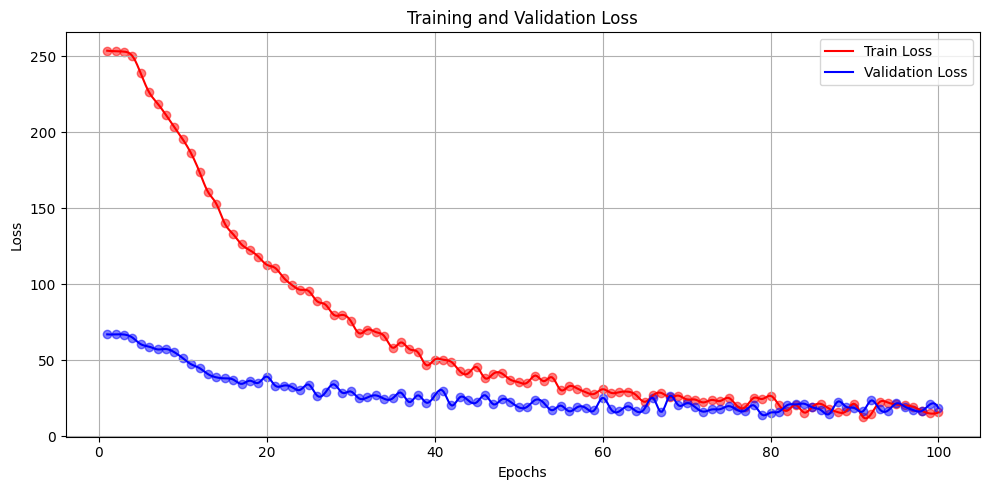

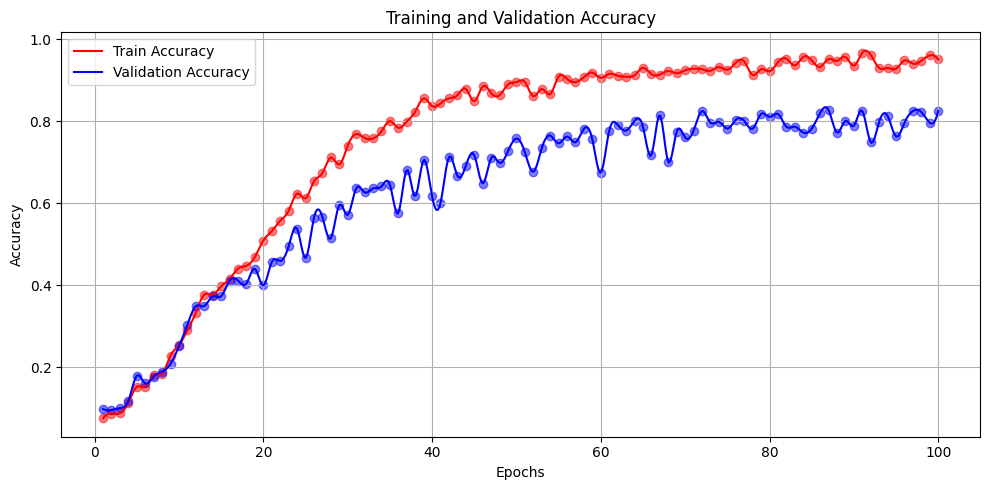

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from google.colab import drive

# Google Drive'ı bağla
drive.mount('/content/drive')

# 'metrics.pkl' dosyasını okuyun
def load_metrics(file_path):
    with open(file_path, "rb") as f:
        metrics_history = pickle.load(f)
    return metrics_history

def plot_metrics_from_file(metrics_history):
    # Epoch numaralarını alın
    epochs = [metrics["epoch"] for metrics in metrics_history]

    # Eğitim ve doğrulama kaybı ve doğruluğunu al
    train_losses = [metrics["train_loss"] for metrics in metrics_history]
    val_losses = [metrics["val_loss"] for metrics in metrics_history]
    train_accuracies = [metrics["train_accuracy"] for metrics in metrics_history]
    val_accuracies = [metrics["val_accuracy"] for metrics in metrics_history]

    # Daha sık aralıklarla epoch değerleri oluşturun
    epochs_new = np.linspace(min(epochs), max(epochs), 500)

    # Kaybı çizmek için spline interpolasyonu
    train_loss_spline = make_interp_spline(epochs, train_losses, k=3)
    train_loss_interpolated = train_loss_spline(epochs_new)

    val_loss_spline = make_interp_spline(epochs, val_losses, k=3)
    val_loss_interpolated = val_loss_spline(epochs_new)

    # Kaybı çiz
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_new, train_loss_interpolated, 'r', label='Train Loss')
    plt.plot(epochs_new, val_loss_interpolated, 'b', label='Validation Loss')
    plt.scatter(epochs, train_losses, color='r', alpha=0.5)
    plt.scatter(epochs, val_losses, color='b', alpha=0.5)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Grafiklerin sıkışıklığını azaltmak için
    plt.show()
    plt.close()

    # Doğruluğu çizmek için spline interpolasyonu
    train_acc_spline = make_interp_spline(epochs, train_accuracies, k=3)
    train_acc_interpolated = train_acc_spline(epochs_new)

    val_acc_spline = make_interp_spline(epochs, val_accuracies, k=3)
    val_acc_interpolated = val_acc_spline(epochs_new)

    # Doğruluğu çiz
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_new, train_acc_interpolated, 'r', label='Train Accuracy')
    plt.plot(epochs_new, val_acc_interpolated, 'b', label='Validation Accuracy')
    plt.scatter(epochs, train_accuracies, color='r', alpha=0.5)
    plt.scatter(epochs, val_accuracies, color='b', alpha=0.5)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Grafiklerin sıkışıklığını azaltmak için
    plt.show()
    plt.close()

# 'metrics.pkl' dosyasının bulunduğu yolu girin
metrics_file_path = "/content/drive/MyDrive/model/hubert100/metrics.pkl"

# Metrics verilerini yükleyin
metrics_history = load_metrics(metrics_file_path)

# Grafikleri çizdirin
plot_metrics_from_file(metrics_history)


In [ ]:
import torch

# GPU belleğini boşalt
torch.cuda.empty_cache()

# CUDA bellek tahsislerini sıfırla
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()

In [ ]:
import gc
import torch

# Tüm gereksiz değişkenleri temizle
gc.collect()
torch.cuda.empty_cache()
